# ***Personal Behaviors Factors to Predict Heart Disease***



***Problem Statement:***

According to the Centers for Disease Control and Prevention (CDC), heart disease is one of the major causes of death in the United States for people of all races (African Americans, American Indians and Alaska Natives, and Whites). High blood pressure, high cholesterol, and smoking are three major risk factors for heart disease that affect over half of all Americans (47 percent).

Diabetic status, obesity (high BMI), lack of physical activity, and excessive alcohol consumption are all important markers. In healthcare, detecting and preventing the factors that have the greatest impact on heart disease is critical. As a result, we'd like to employ Machine Learning to assist doctors and researchers in better understanding and predicting cardiac disease before it becomes a serious problem for patients.

***Data Source:***

Kaggle: [2020 annual CDC survey data of 400k adults related to their health status.](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease)



In [95]:
#import library 
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM,SGDClassifier
! pip install category_encoders
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import Isomap 
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import boxcox
import seaborn as sns
! pip install xgboost
from xgboost import XGBClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
! pip install imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
! pip install shap
import shap


     |████████████████████████████████| 433 kB 1.8 MB/s eta 0:00:01


In [2]:
#read data
df = pd.read_csv('heart_2020_cleaned.csv')

In [3]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [4]:
#check missing data
df.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [5]:
#check target variable
df['HeartDisease'].value_counts(normalize=True)

No     0.914405
Yes    0.085595
Name: HeartDisease, dtype: float64

***This is an unbalanced dataset thus we have to oversample or undersample before training our models.***

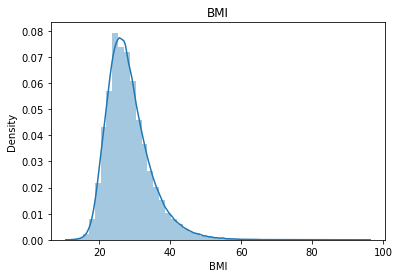

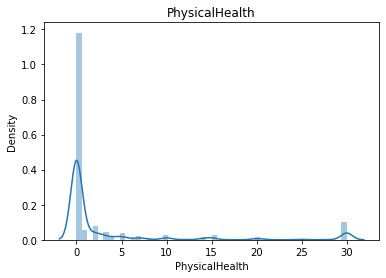

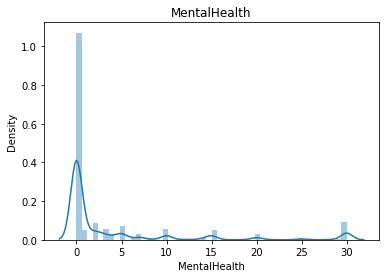

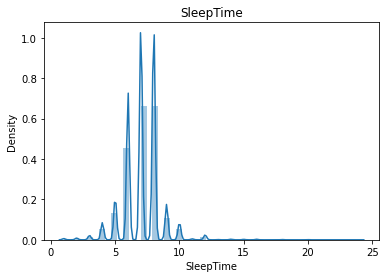

In [6]:
#check numeric columns
for col in df.dtypes[df.dtypes!='object'].index.to_list():
        sns.distplot(df[col])
        plt.title(col)
        plt.show()

 ***There are two columns - SleepTime and BMI - have outliers which are SleepTime (greater than 12
hours and up to 24 hours) and BMI (greater than 50 and up to 100).
In general, there are some people who have very high BMI scores but it is very rare and BMI scores
distribution will range from 20 to 50. In addition, sleeping time distribution range from 5 hours to 12
hours, it is very rare and nearly impossible that people can sleep over 12 hours and up to 24 hours a
day - except for patients in a coma (should be excluded as well). Thus we have to remove those values.***

In [7]:
#remove outliers in SleepTime and BMI
df = df[(df['SleepTime']>=5) & (df['SleepTime']<= 12)].reset_index(drop=True)
df = df[(df['BMI']>=20) & (df['BMI']<= 50)].reset_index(drop=True)
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
1,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
2,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
3,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No
4,Yes,28.87,Yes,No,No,6.0,0.0,Yes,Female,75-79,Black,No,No,Fair,12.0,No,No,No


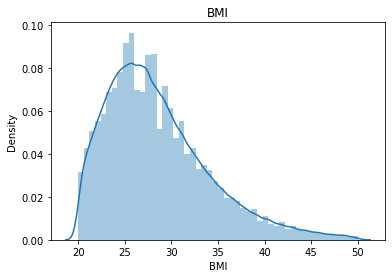

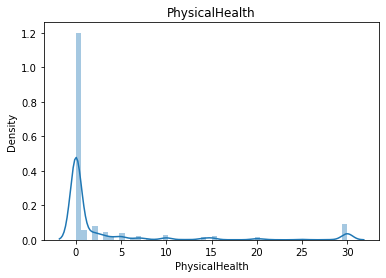

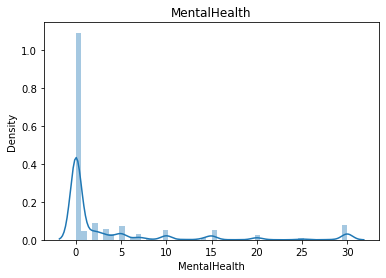

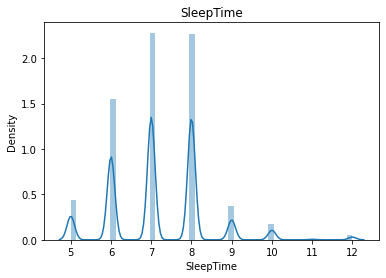

In [8]:
#check numeric columns
for col in df.dtypes[df.dtypes!='object'].index.to_list():
        sns.distplot(df[col])
        plt.title(col)
        plt.show()

**After removing some outliers, our numeric features look great. However, I want to use log10 and Box-Cox techniques to transform the BMI feature from right skewed to nearly normal distribution.**

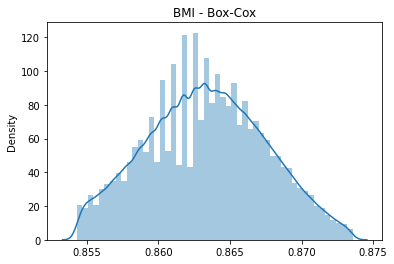

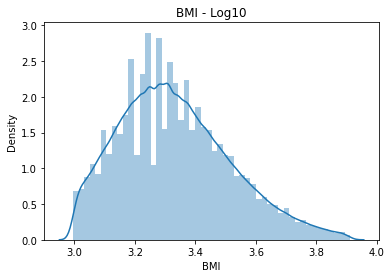

In [9]:
sns.distplot(boxcox(df['BMI'])[0])
plt.title('BMI - Box-Cox')
plt.show()
sns.distplot(np.log(df['BMI']))
plt.title('BMI - Log10')
plt.show()

**Overall, the Box-Cox technique did a great job to transform our feature to nearly normal distribution.**

In [10]:
#Use Box-Cox to tranform BMI feature 
df['BMI'] = boxcox(df['BMI'])[0]

In [11]:
#check object columns
for col in df.dtypes[df.dtypes=='object'].index.to_list():
  print(df[col].value_counts())

No     267129
Yes     24382
Name: HeartDisease, dtype: int64
No     172739
Yes    118772
Name: Smoking, dtype: int64
No     271812
Yes     19699
Name: AlcoholDrinking, dtype: int64
No     281105
Yes     10406
Name: Stroke, dtype: int64
No     254100
Yes     37411
Name: DiffWalking, dtype: int64
Female    150066
Male      141445
Name: Sex, dtype: int64
65-69          31714
60-64          30837
70-74          28888
55-59          27258
50-54          23214
80 or older    21837
45-49          19995
75-79          19912
40-44          19176
35-39          18614
18-24          17880
30-34          16968
25-29          15218
Name: AgeCategory, dtype: int64
White                             224902
Hispanic                           24986
Black                              20478
Other                               9578
Asian                               6970
American Indian/Alaskan Native      4597
Name: Race, dtype: int64
No                         246010
Yes                         37018
No

***Transforming binary columns (Yes/No) or (Male/Female) to (1/0)***

In [12]:
df['SkinCancer'].replace('N','No',inplace=True)
for binary_col in ['SkinCancer','KidneyDisease','Asthma','PhysicalActivity','DiffWalking','Stroke','AlcoholDrinking','Smoking','HeartDisease']:
  df[binary_col].replace(['No','Yes'],[0,1],inplace=True)
df['Sex'].replace(['Female','Male'],[0,1],inplace=True)
df['Diabetic'].replace(['No','Yes','No, borderline diabetes','Yes (during pregnancy)'],[1,3,2,4],inplace=True)
df

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,0.854865,0,0,1,0.0,0.0,0,0,80 or older,White,1,1,Very good,7.0,0,0,0
1,0,0.862514,1,0,0,20.0,30.0,0,1,65-69,White,3,1,Fair,8.0,1,0,0
2,0,0.860103,0,0,0,0.0,0.0,0,0,75-79,White,1,0,Good,6.0,0,0,1
3,0,0.859529,0,0,0,28.0,0.0,1,0,40-44,White,1,1,Very good,8.0,0,0,0
4,1,0.864446,1,0,0,6.0,0.0,1,0,75-79,Black,1,0,Fair,12.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291506,1,0.863254,1,0,0,7.0,0.0,1,1,60-64,Hispanic,3,0,Fair,6.0,1,0,0
291507,0,0.865169,1,0,0,0.0,0.0,0,1,35-39,Hispanic,1,1,Very good,5.0,1,0,0
291508,0,0.860137,0,0,0,0.0,0.0,0,0,45-49,Hispanic,1,1,Good,6.0,0,0,0
291509,0,0.867101,0,0,0,0.0,0.0,0,0,25-29,Hispanic,1,0,Good,12.0,0,0,0


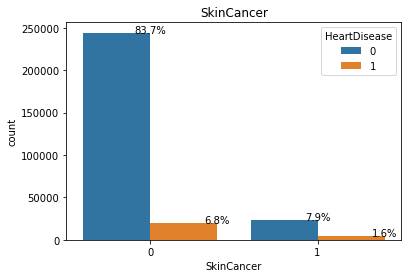

Heart Disease vs No Heart Disease ratio when: 
 SkinCancer = No is 0.09 
 SkinCancer = Yes is 0.23
Final ratio changed is : 143.98 %


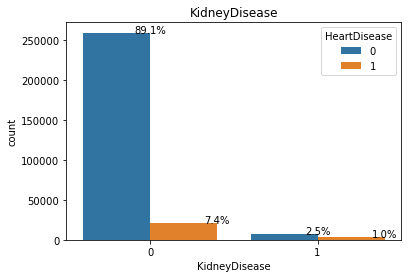

Heart Disease vs No Heart Disease ratio when: 
 KidneyDisease = No is 0.03 
 KidneyDisease = Yes is 0.14
Final ratio changed is : 385.22 %


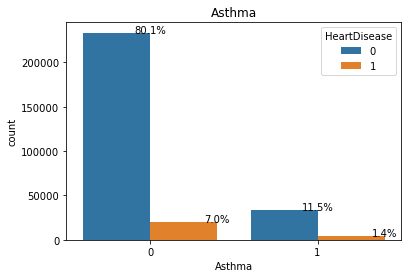

Heart Disease vs No Heart Disease ratio when: 
 Asthma = No is 0.14 
 Asthma = Yes is 0.2
Final ratio changed is : 39.7 %


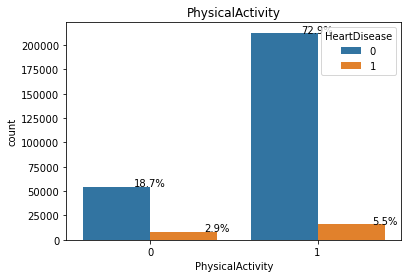

Heart Disease vs No Heart Disease ratio when: 
 PhysicalActivity = No is 3.9 
 PhysicalActivity = Yes is 1.9
Final ratio changed is : -51.21 %


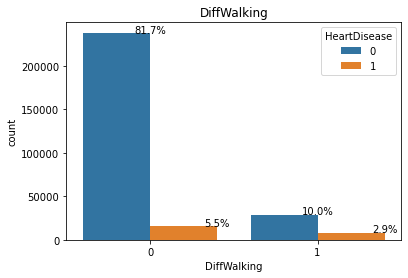

Heart Disease vs No Heart Disease ratio when: 
 DiffWalking = No is 0.12 
 DiffWalking = Yes is 0.52
Final ratio changed is : 327.61 %


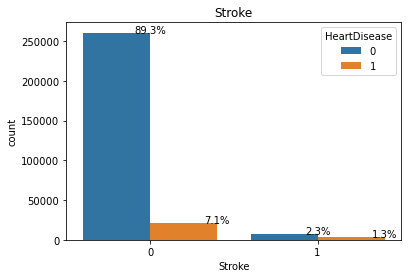

Heart Disease vs No Heart Disease ratio when: 
 Stroke = No is 0.03 
 Stroke = Yes is 0.18
Final ratio changed is : 592.45 %


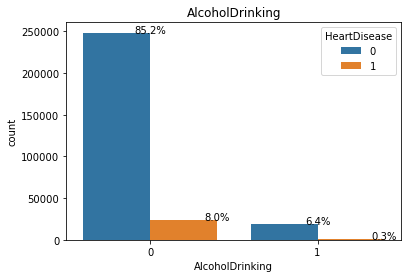

Heart Disease vs No Heart Disease ratio when: 
 AlcoholDrinking = No is 0.08 
 AlcoholDrinking = Yes is 0.04
Final ratio changed is : -43.99 %


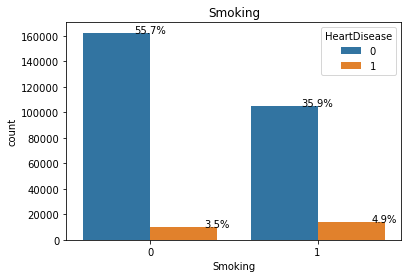

Heart Disease vs No Heart Disease ratio when: 
 Smoking = No is 0.64 
 Smoking = Yes is 1.38
Final ratio changed is : 114.84 %


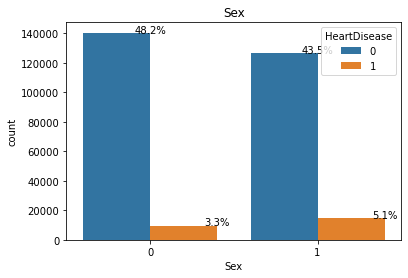

Heart Disease vs No Heart Disease ratio when: 
 Sex = No is 0.9 
 Sex = Yes is 1.54
Final ratio changed is : 70.38 %


In [13]:
total = float(len(df))
for col in ['SkinCancer','KidneyDisease','Asthma','PhysicalActivity','DiffWalking','Stroke','AlcoholDrinking','Smoking','Sex']:
    percentages =[]
    ax= sns.countplot(data=df,x=col,hue='HeartDisease')
    for p in ax.patches:
      percentage = '{:.1f}%'.format(100 * p.get_height()/total)
      x = p.get_x() + p.get_width()
      y = p.get_height()
      ax.annotate(percentage, (x, y),ha='center')
      percentages.append(p.get_height()/total)
    plt.title(col)
    plt.show()
    rate_1 = percentages[1]/percentages[0]
    rate_2 = percentages[3]/percentages[2]
    print('Heart Disease vs No Heart Disease ratio when: \n {} = No is {} \n {} = Yes is {}'
    .format(col,round(rate_1,2),col,round(rate_2,2)))
    print('Final ratio changed is : {} %'.format(round((rate_2-rate_1)/rate_1*100,2)))

In [14]:
for col in df.dtypes[df.dtypes=='object'].index.to_list():
  print(df[col].value_counts())

65-69          31714
60-64          30837
70-74          28888
55-59          27258
50-54          23214
80 or older    21837
45-49          19995
75-79          19912
40-44          19176
35-39          18614
18-24          17880
30-34          16968
25-29          15218
Name: AgeCategory, dtype: int64
White                             224902
Hispanic                           24986
Black                              20478
Other                               9578
Asian                               6970
American Indian/Alaskan Native      4597
Name: Race, dtype: int64
Very good    106618
Good          85429
Excellent     61377
Fair          29677
Poor           8410
Name: GenHealth, dtype: int64


**We will use Target Encoder for AgeCategory and Race features and Ordinal Encoder for GenHealth feature.**

In [15]:
df['AgeCategory'] = TargetEncoder().fit_transform(df['AgeCategory'],df['HeartDisease'])
df['Race'] = TargetEncoder().fit_transform(df['Race'],df['HeartDisease'])
df['GenHealth'].replace(['Poor','Fair','Good','Very good','Excellent'],[1,2,3,4,5],inplace=True)

In [16]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,0.854865,0,0,1,0.0,0.0,0,0,0.226542,0.090190,1,1,4,7.0,0,0,0
1,0,0.862514,1,0,0,20.0,30.0,0,1,0.117204,0.090190,3,1,2,8.0,1,0,0
2,0,0.860103,0,0,0,0.0,0.0,0,0,0.188379,0.090190,1,0,3,6.0,0,0,1
3,0,0.859529,0,0,0,28.0,0.0,1,0,0.019504,0.090190,1,1,4,8.0,0,0,0
4,1,0.864446,1,0,0,6.0,0.0,1,0,0.188379,0.071491,1,0,2,12.0,0,0,0


In [17]:
#shuffle data
df_shuffle = shuffle(df.copy(),random_state=42)
y = df_shuffle['HeartDisease'].copy()
X = df_shuffle.iloc[:,1:].copy()
X = StandardScaler().fit_transform(X)

In [18]:
#use One Class Support Vector Machine to detect outliers in dataset. 
One_ClassSVM = SGDOneClassSVM(nu=0.05, shuffle=True, fit_intercept=True, random_state=42, tol=1e-4)
One_ClassSVM.fit(X)

SGDOneClassSVM(nu=0.05, random_state=42, tol=0.0001)

In [19]:
labels = One_ClassSVM.fit_predict(X)

In [20]:
df_shuffle['labels'] = labels
df_shuffle['labels'].value_counts()

 1    255702
-1     35809
Name: labels, dtype: int64

**There are 35809 outliers in our dataset, thus we should remove them before train our model.**

In [21]:
df_shuffle= df_shuffle[df_shuffle['labels']==1].reset_index(drop=True)
y = df_shuffle['HeartDisease'].copy()
X = df_shuffle.iloc[:,1:].copy()
X.drop('labels',axis=1,inplace=True)

**Next, we will use ExtraTreesClassifier to select top features in our dataset.**

In [22]:
clf = ExtraTreesClassifier(n_estimators=100,random_state=42)
clf.fit(X,y)

ExtraTreesClassifier(random_state=42)

In [23]:
feature_scores,feature_names = list(zip(*(sorted(zip(clf.feature_importances_,X.columns),reverse=True))))

Text(0.5, 1.0, 'Tree-based feature selection')

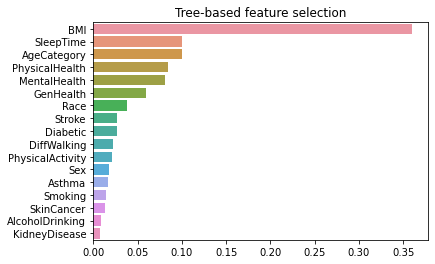

In [24]:
sns.barplot(list(feature_scores),list(feature_names))
plt.title('Tree-based feature selection')

In [25]:
X_10 = X.loc[:,feature_names[:10]]

***We will only use top 10 important features to train models.***

In [26]:
#split data into 2 parts - train and test
X_train, X_test, y_train, y_test = train_test_split(X_10, y, test_size=0.2, random_state=42)

In [27]:
#check test target variable ratio 
y_test.value_counts(normalize=True)

0    0.917131
1    0.082869
Name: HeartDisease, dtype: float64

In [28]:
#check train target variable ratio
y_train.value_counts(normalize=True)

0    0.918508
1    0.081492
Name: HeartDisease, dtype: float64

**Our dataset is imbalanced thus we have to undersample the majority class (No Heart Disease) to let our model learn without bias.**

In [29]:
#use sampling_strategy = auto
steps = [('under', RandomUnderSampler(sampling_strategy='auto',random_state=42))]
pipeline = Pipeline(steps=steps)

In [30]:
X_train,y_train = pipeline.fit_resample(X_train,y_train)

In [31]:
#check our train target feature ratio
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: HeartDisease, dtype: float64

In [50]:
models =['LogisticRegression','DecisionTreeClassifier','SVC','KNeighborsClassifier','AdaBoostClassifier','RandomForestClassifier','GaussianNB','GradientBoostingClassifier','XGBClassifier']

In [49]:
clf1 = LogisticRegression(random_state=42,solver='saga')
clf2 = DecisionTreeClassifier(random_state=42)
clf3 = SGDClassifier(loss='modified_huber',random_state=42)
clf4 = KNeighborsClassifier()
clf5 = AdaBoostClassifier(random_state=42,algorithm='SAMME')
clf6 = RandomForestClassifier(random_state=42)
clf7 = GaussianNB()
clf8 = GradientBoostingClassifier(random_state=42)
clf9 = XGBClassifier(objective= 'binary:logistic',random_state=42,)
clf  = [clf1,clf2,clf3,clf4,clf5,clf6,clf7,clf8,clf9]

In [48]:
param1= {'penalty':['l1','l2','elasticnet'],
         'C':np.linspace(0.001,1,10)}
param2 = {'max_depth':[3,10,15,None],
          'max_features':['auto','sqrt','log2'],
          'min_samples_split':[2,5,10]}
param3 = {'penalty':['l1','l2']
          } 
param4 = {'n_neighbors':np.arange(3,15,2),
          'weights': ['uniform', 'distance'],
          'metric':['euclidean','manhattan']
          }
param5 = {'n_estimators': [50,250,500],
          'learning_rate':[0.01,0.05,0.1]
    }
param6 = {'n_estimators':[100,300,500],
          'max_features':['auto','sqrt'],
          'criterion': ['gini','entropy'],
          'max_depth':[3,10,15]
      }
param7 = {'var_smoothing': [1e-11, 1e-10, 1e-9]}

param8 = {'loss':['deviance','exponential'],
          'learning_rate': [0.01,0.05,0.1],
          'n_estimators': [100,300,500],
          'max_depth': [3,10,15]
          }
param9 = {'max_depth': [3,10,15],
          'n_estimators': [100,300,500],
          'learning_rate': [0.01],
          'gamma': [i/10.0 for i in range(3)]
        }
params = [param1,param2,param3,param4,param5,param6,param7,param8,param9]

In [51]:
accuracy_scores = []
precision_scores = []
recall_scores = []
roc_auc_scores = []
F1_scores = []
paramenters = []
for i in range(9):
  print('Training {}...'.format(models[i]))
  gs_model = GridSearchCV(clf[i],params[i],verbose=1,cv=5,n_jobs=-1,scoring='roc_auc')
  gs_model.fit(X_train,y_train)
  #gs_model = gs.best_estimator_.fit(X_train,y_train)
  y_pred= gs_model.predict(X_test)
  accuracy_scores.append(accuracy_score(y_test,y_pred))
  precision_scores.append(precision_score(y_test,y_pred))
  recall_scores.append(recall_score(y_test,y_pred))
  roc_auc_scores.append(roc_auc_score(y_test,gs_model.predict_proba(X_test)[:, 1]))
  F1_scores.append(f1_score(y_test,y_pred))
  paramenters.append(gs_model.best_params_)
  print(classification_report(y_test,y_pred))
  print('Done')

Training LogisticRegression...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/khoadao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/khoadao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/khoadao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/khoadao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/khoadao/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/khoadao/opt/anaconda3/lib/python3

              precision    recall  f1-score   support

           0       0.97      0.75      0.85     46903
           1       0.21      0.73      0.33      4238

    accuracy                           0.75     51141
   macro avg       0.59      0.74      0.59     51141
weighted avg       0.91      0.75      0.80     51141

Done
Training DecisionTreeClassifier...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
              precision    recall  f1-score   support

           0       0.97      0.68      0.80     46903
           1       0.18      0.80      0.30      4238

    accuracy                           0.69     51141
   macro avg       0.58      0.74      0.55     51141
weighted avg       0.91      0.69      0.76     51141

Done
Training SVC...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
              precision    recall  f1-score   support

           0       0.97      0.71      0.82     46903
           1       0.20      0.77      0.31      4238


In [59]:
df_report= pd.DataFrame()
df_report['Model'] = models
df_report['Accuracy_scores'] = accuracy_scores
df_report['Precision_scores'] = precision_scores
df_report['Recall_scores'] = recall_scores
df_report['Roc_auc_scores'] = roc_auc_scores
df_report['F1_scores'] = F1_scores
df_report['paras'] = paramenters
df_report = df_report.sort_values(by='Roc_auc_scores',ascending=False).reset_index(drop=True)
df_report

,Model,Accuracy_scores,Precision_scores,Recall_scores,Roc_auc_scores,F1_scores,paras
0,GradientBoostingClassifier,0.699321,0.190875,0.811468,0.826923,0.309054,"{'learning_rate': 0.1, 'loss': 'deviance', 'ma..."
1,XGBClassifier,0.695157,0.189123,0.814771,0.825970,0.306988,"{'gamma': 0.0, 'learning_rate': 0.01, 'max_dep..."
2,RandomForestClassifier,0.695626,0.188860,0.811232,0.825959,0.306390,"{'criterion': 'entropy', 'max_depth': 10, 'max..."
3,AdaBoostClassifier,0.726306,0.201359,0.776310,0.823580,0.319775,"{'learning_rate': 0.1, 'n_estimators': 500}"
4,LogisticRegression,0.751765,0.210951,0.728174,0.821132,0.327132,"{'C': 1.0, 'penalty': 'l1'}"
5,SVC,0.718856,0.195861,0.770411,0.815878,0.312321,{'penalty': 'l1'}
6,DecisionTreeClassifier,0.689251,0.183934,0.800142,0.805097,0.299109,"{'max_depth': 10, 'max_features': 'auto', 'min..."
7,GaussianNB,0.794079,0.218484,0.576215,0.801305,0.316834,{'var_smoothing': 1e-09}
8,KNeighborsClassifier,0.696525,0.181191,0.756489,0.788599,0.292358,"{'metric': 'manhattan', 'n_neighbors': 13, 'we..."


**Gradient Boosting Classifier has highest ROC AUC score comparing to others model thus we will retrain the model with all train data and test the performance on test data.**

In [38]:
def get_result(model):
    print('Accuracy score: {} '.format(round(accuracy_score(y_test,model.predict(X_test)),2)))
    print('Precision score: {} '.format(round(precision_score(y_test,model.predict(X_test)),2)))
    print('Recall score: {} '.format(round(recall_score(y_test,model.predict(X_test)),2)))
    print('Roc Auc score: {} '.format(round(roc_auc_score(y_test,model.predict_proba(X_test)[:, 1]),2)))
    print('F1 score: {} '.format(round(f1_score(y_test,model.predict(X_test)),2)))
    print(classification_report(y_test,model.predict(X_test)))
    cm = confusion_matrix(y_test, model.predict(X_test))
    from matplotlib.pyplot import figure
    figure(dpi=500)
    ax = sns.heatmap(cm/np.sum(cm), annot=True, cmap='PuRd', fmt='.2%')
    
    ax.set_title('AdaBoost Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['No HeartDisease','HeartDisease'])
    ax.yaxis.set_ticklabels(['No HeartDisease','HeartDisease'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    from matplotlib.pyplot import figure

    figure(dpi=500)
    ax = plt.gca()
    knn_disp = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax)
    plt.show()

In [67]:
final_model = GradientBoostingClassifier(random_state=42,learning_rate=0.1,loss='deviance',max_depth=3,n_estimators=100)
final_model.fit(X_train,y_train)

GradientBoostingClassifier(random_state=42)

In [96]:
# Fits the explainer
explainer = shap.Explainer(final_model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Exact explainer: 51142it [18:25, 45.93it/s]                           


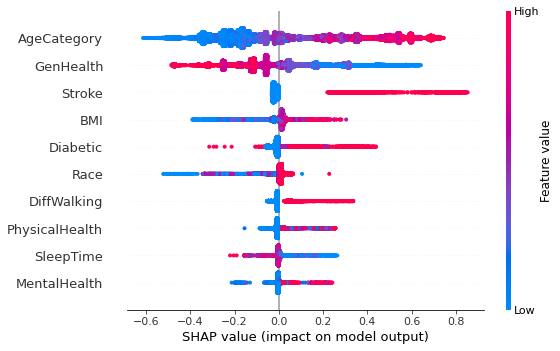

In [97]:
shap.summary_plot(shap_values)

Accuracy score: 0.7 
Precision score: 0.19 
Recall score: 0.81 
Roc Auc score: 0.83 
F1 score: 0.31 
              precision    recall  f1-score   support

           0       0.98      0.69      0.81     46903
           1       0.19      0.81      0.31      4238

    accuracy                           0.70     51141
   macro avg       0.58      0.75      0.56     51141
weighted avg       0.91      0.70      0.77     51141



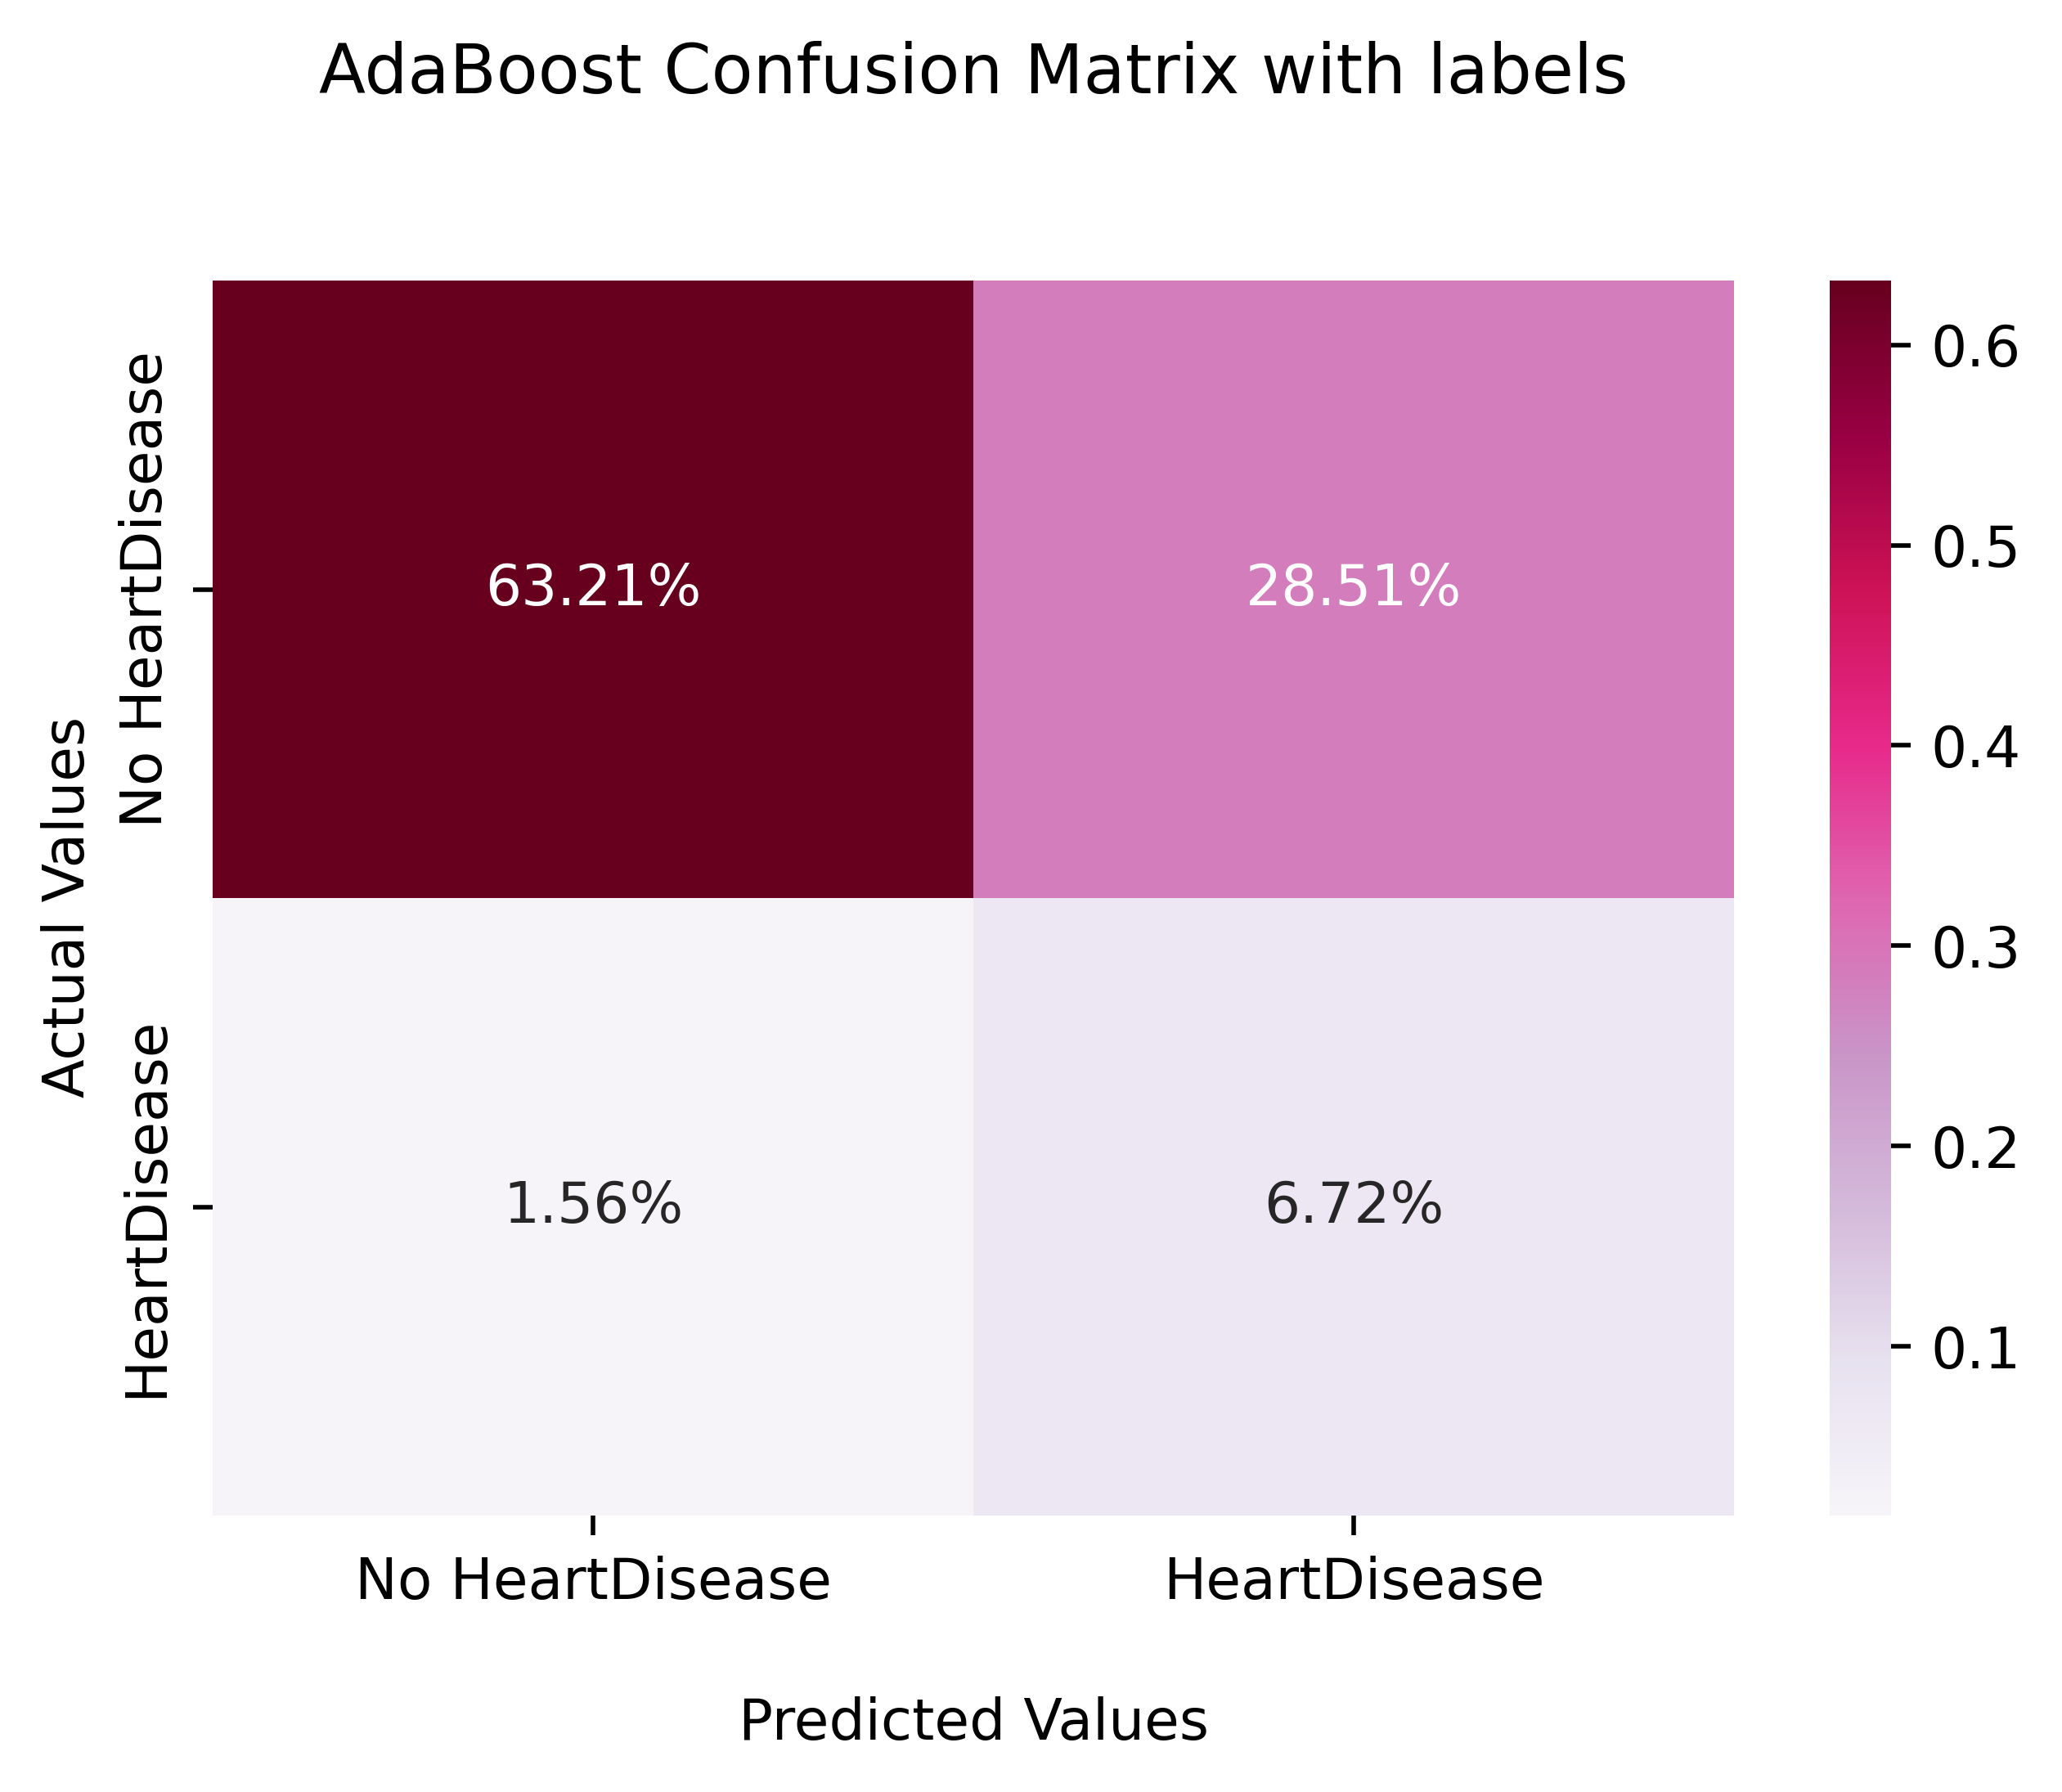

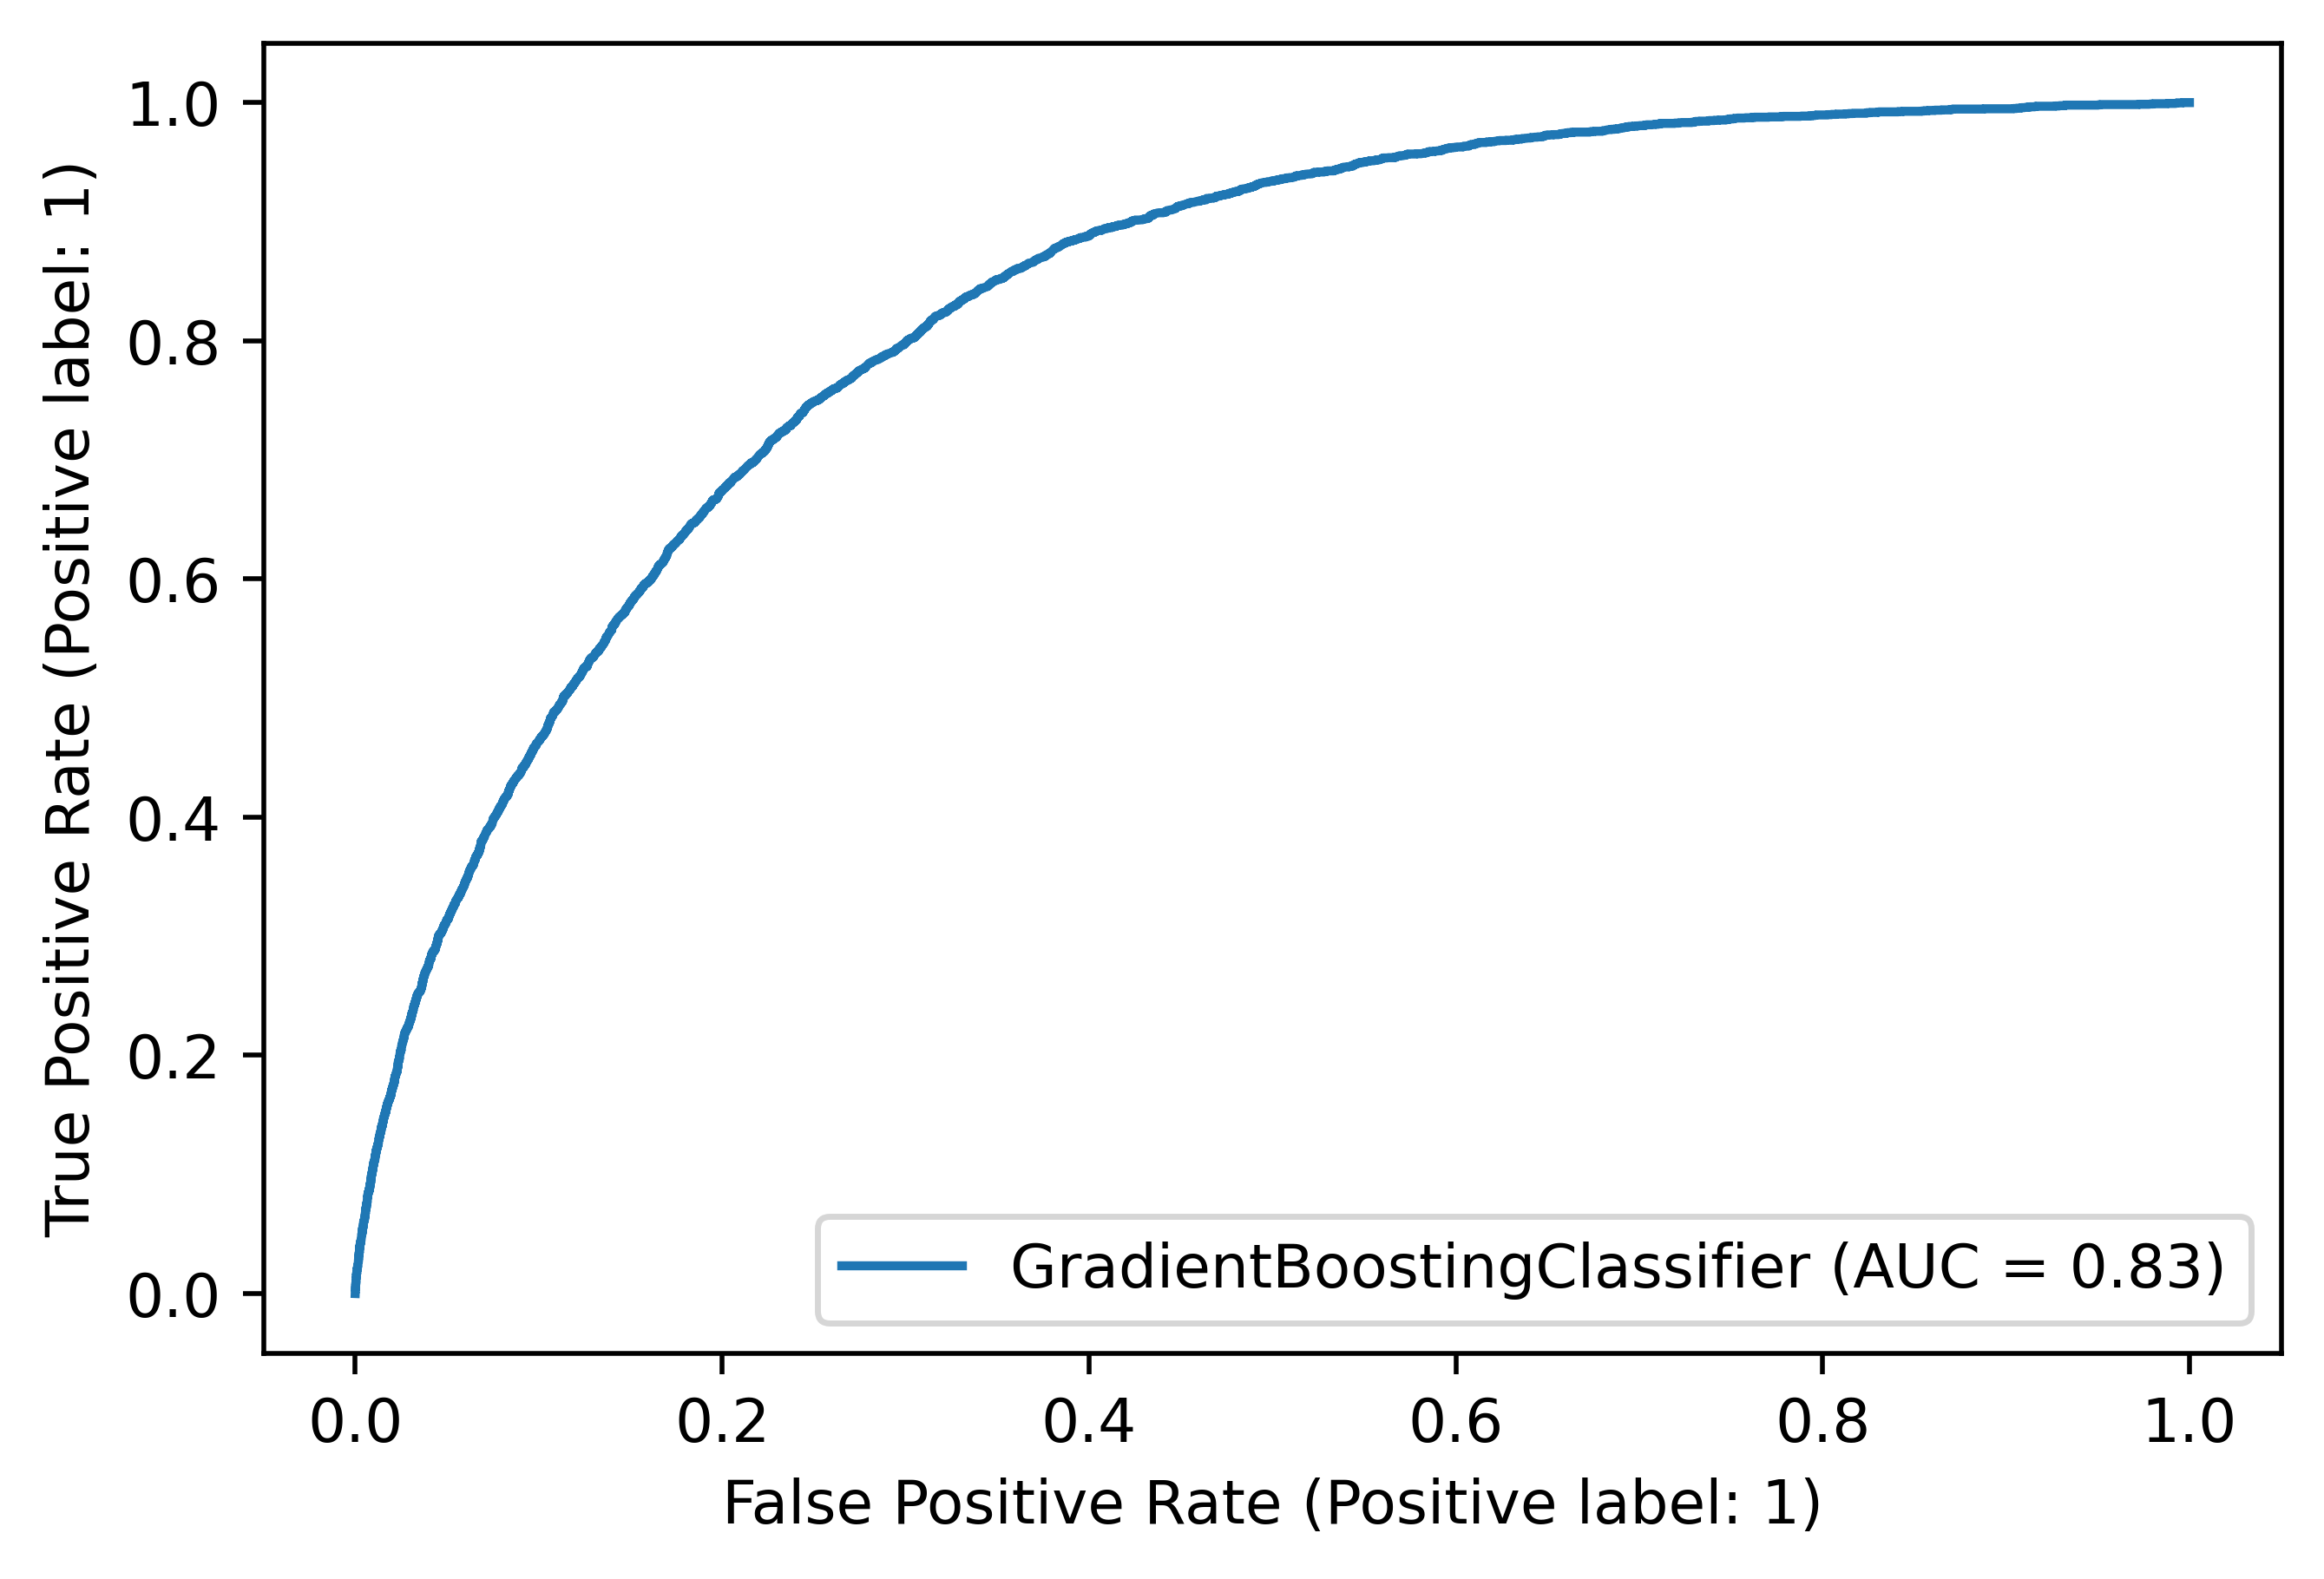

In [68]:
get_result(final_model)

<b><i>After training Gradient Boosting Classifier model, our model can capture (81 percentage) of heart disease cases in our test data set. Unfortunately, Gradient Boosting Classifier has quite low precision score (20 percentage). As mentioned above, the cost of missing a heart disease case is higher than others and we can run other diagnostic test (X-ray) later to determine whether our patients have heart disease or not. In additional, our survey data is easy to collect and do not require run any medical diagnostic test (only use historical medical record), thus we can use predictions to encourage surveyor take medical diagnostic test. 
